üöÄ Starting Enhanced Credit Approval Model Training
üìä Loading and preparing data...
Application records: 438557 rows
Credit records: 1048575 rows
Merged dataset: 36457 rows
Target distribution: {0: 35841, 1: 616}
üîß Engineering new features...
Total features after engineering: 27
üìà Performing exploratory data analysis...


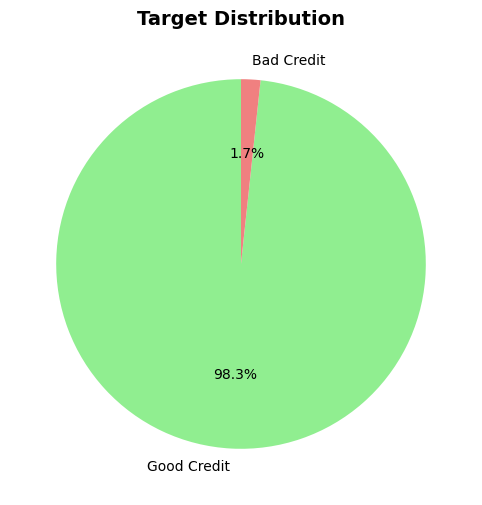

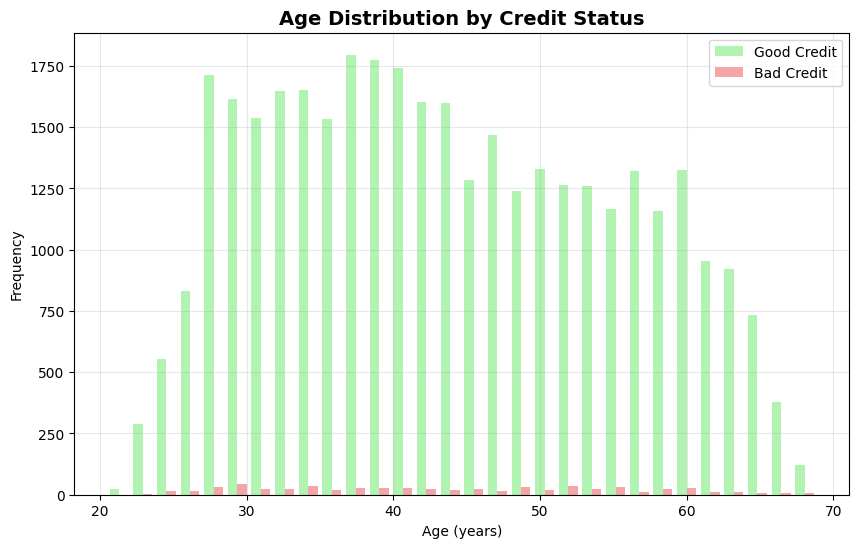

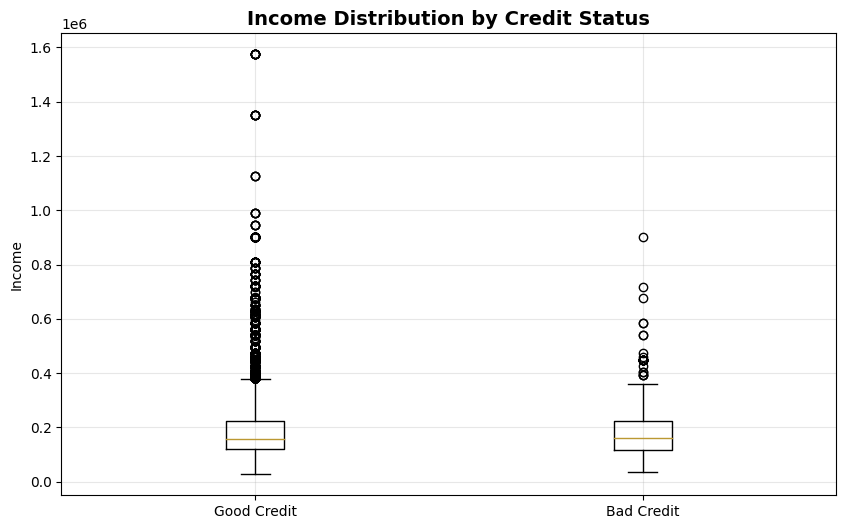

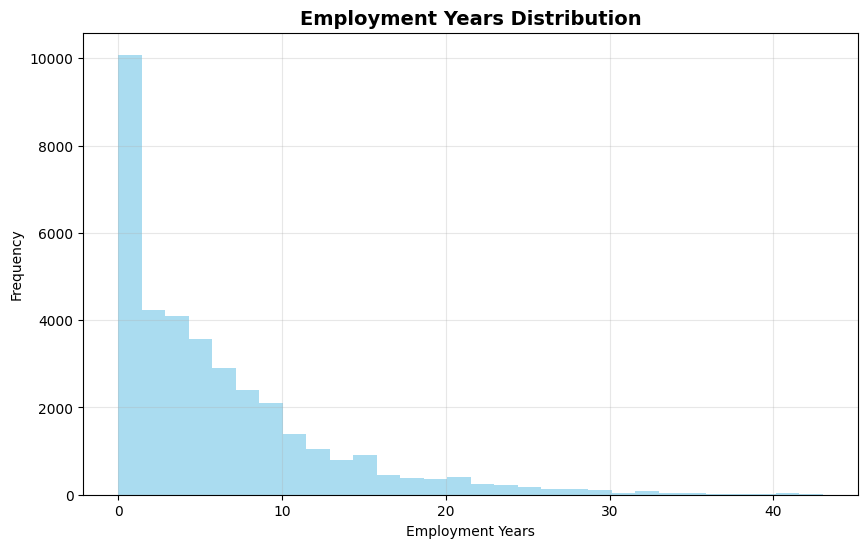

<Figure size 1200x600 with 0 Axes>

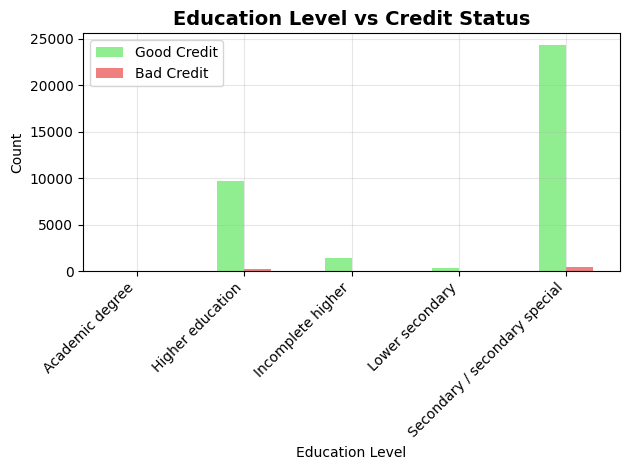

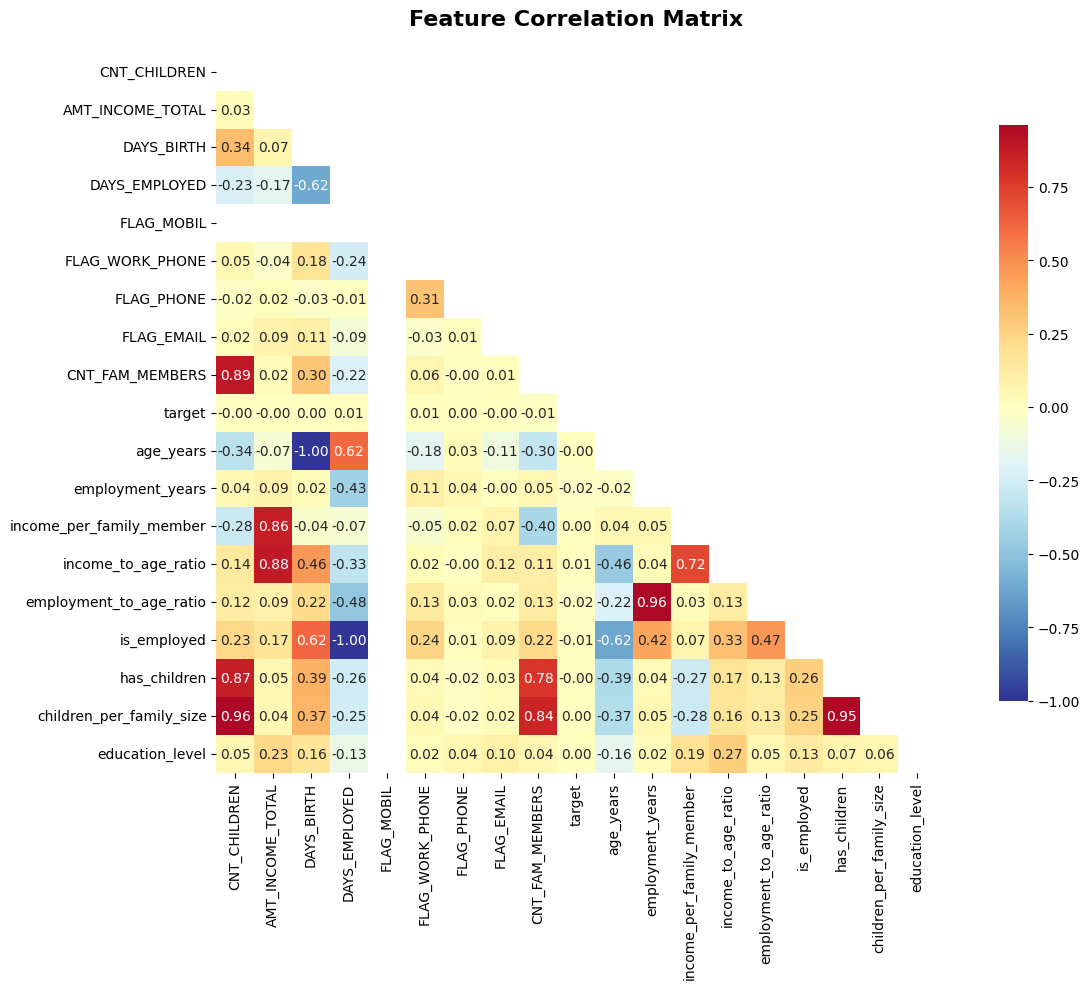


üìä Statistical Summary:
Dataset shape: (36457, 27)
Missing values per column:
OCCUPATION_TYPE    11323
dtype: int64
üéØ Preparing features for modeling...
Categorical features (8): ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
Numerical features (18): 18
‚öôÔ∏è Creating preprocessing pipelines...
üìä Splitting data into training and testing sets...
Training set: 29165 samples
Testing set: 7292 samples
ü§ñ Training multiple models for comparison...

üîÑ Training and evaluating Random Forest...
Random Forest Results:
  üìä Cross-Validation:
    ‚Ä¢ Accuracy: 0.9687 (¬±0.0011)
    ‚Ä¢ ROC AUC:  0.7767 (¬±0.0166)
    ‚Ä¢ F1 Score: 0.3148 (¬±0.0221)
  üéØ Test Results:
    ‚Ä¢ Accuracy: 0.9624
    ‚Ä¢ ROC AUC:  0.7974
    ‚Ä¢ F1 Score: 0.2514
  ‚öñÔ∏è  Final Score: 0.6800

üîÑ Training and evaluating Gradient Boosting...
Gradient Boosting Results:
  üìä Cross-Validation:


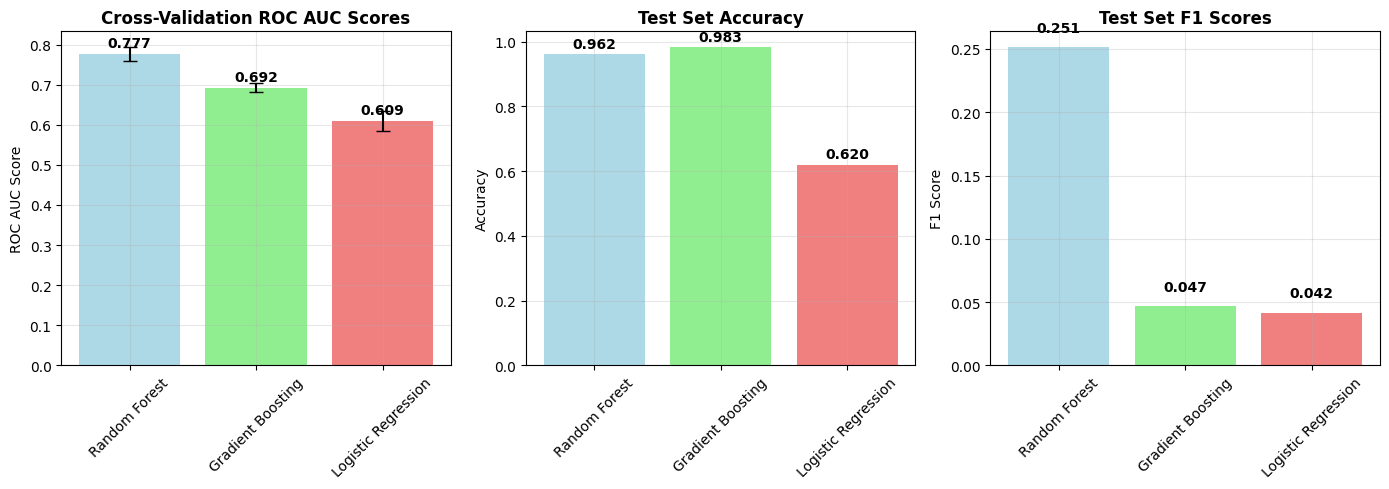

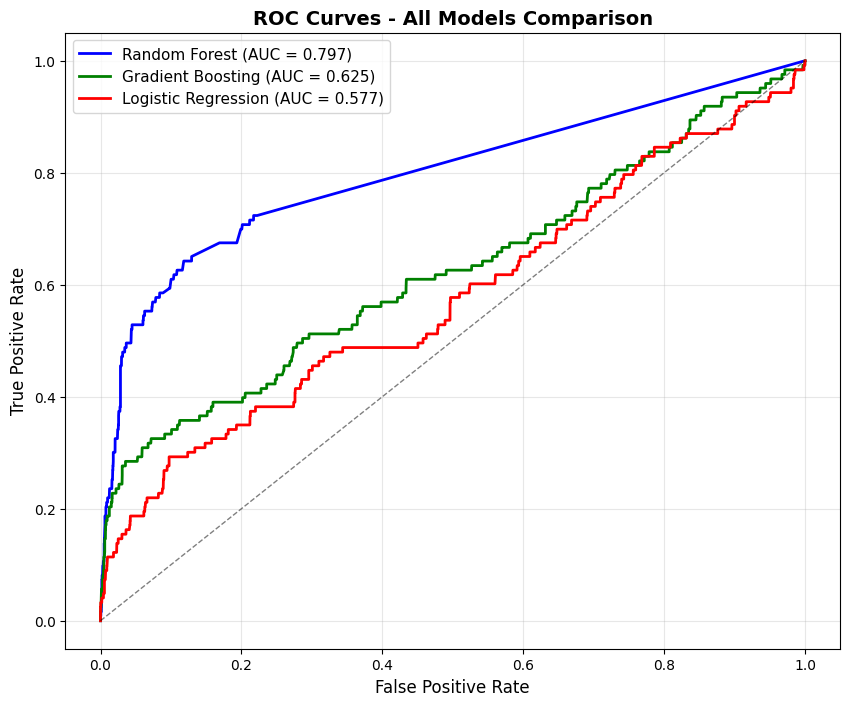

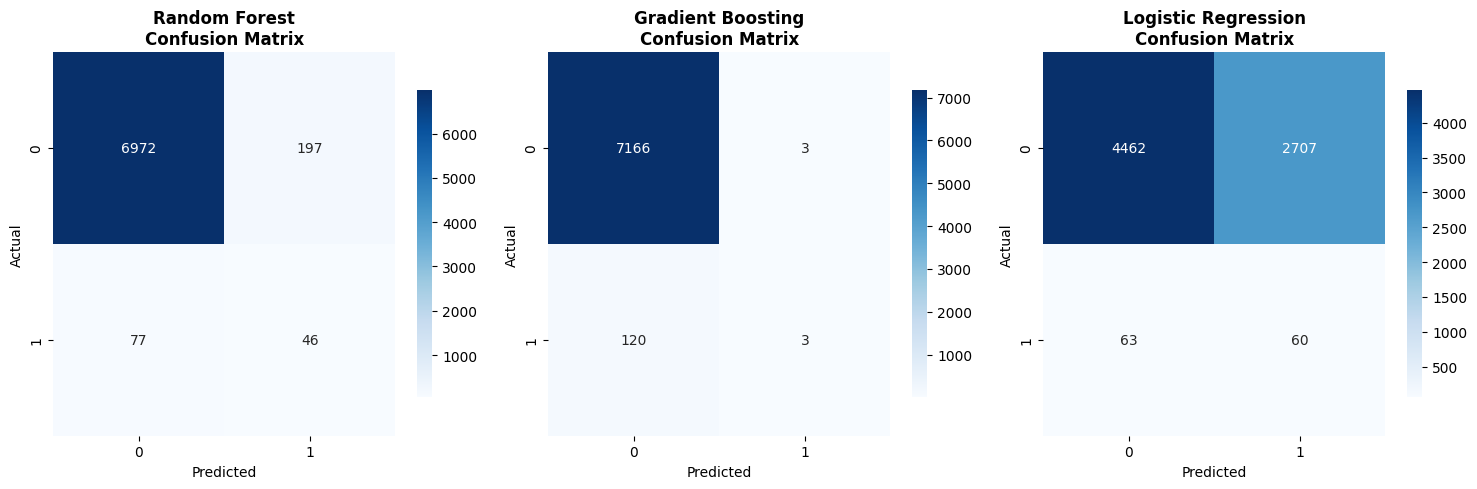


üìã Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7169
           1       0.19      0.37      0.25       123

    accuracy                           0.96      7292
   macro avg       0.59      0.67      0.62      7292
weighted avg       0.98      0.96      0.97      7292


üìã Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7169
           1       0.50      0.02      0.05       123

    accuracy                           0.98      7292
   macro avg       0.74      0.51      0.52      7292
weighted avg       0.98      0.98      0.98      7292


üìã Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      7169
           1       0.02      0.49      0.04       123

    accuracy                         

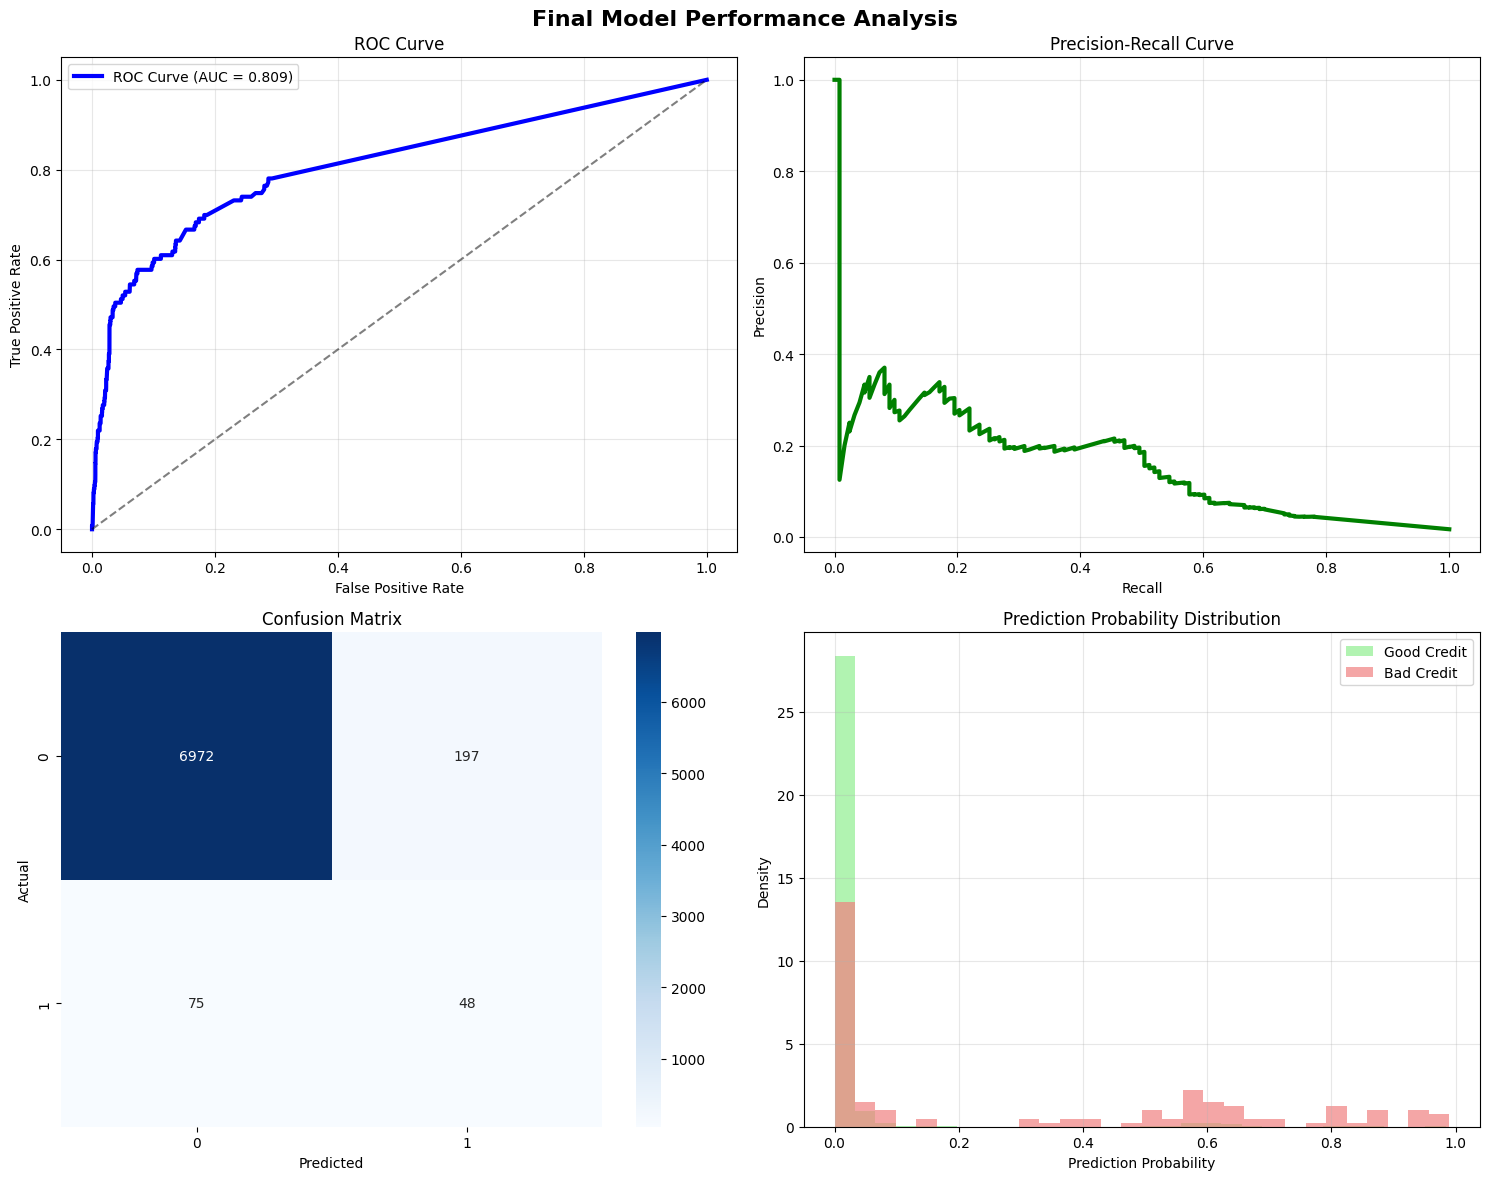


üìã Final Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7169
           1       0.20      0.39      0.26       123

    accuracy                           0.96      7292
   macro avg       0.59      0.68      0.62      7292
weighted avg       0.98      0.96      0.97      7292

üîç Analyzing feature importance...


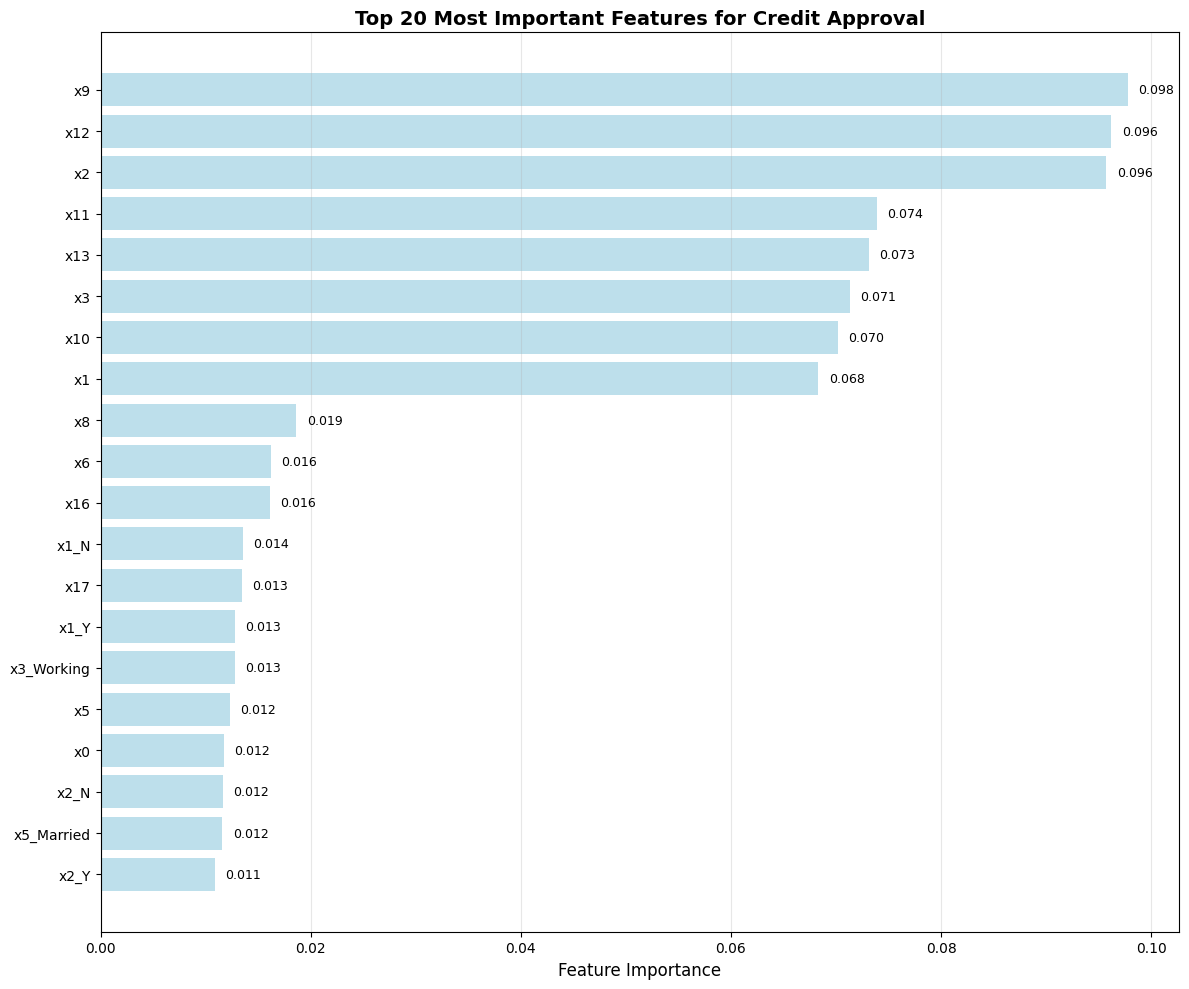


üéØ Top 10 Most Important Features:
 1. x9                                      : 0.0978
 2. x12                                     : 0.0962
 3. x2                                      : 0.0957
 4. x11                                     : 0.0739
 5. x13                                     : 0.0732
 6. x3                                      : 0.0713
 7. x10                                     : 0.0702
 8. x1                                      : 0.0683
 9. x8                                      : 0.0186
10. x6                                      : 0.0162
üíæ Saving model to enhanced_credit_approval_model.pkl...
‚úÖ Model successfully saved as 'enhanced_credit_approval_model.pkl'

üéâ MODEL TRAINING COMPLETED SUCCESSFULLY!

üìä ALL MODELS COMPARISON:
--------------------------------------------------
Random Forest:
  ‚Ä¢ CV ROC AUC:    0.7767 ¬± 0.0166
  ‚Ä¢ Test Accuracy: 0.9624
  ‚Ä¢ Test ROC AUC:  0.7974
  ‚Ä¢ Test F1 Score: 0.2514

Gradient Boosting:
  ‚Ä¢ CV ROC AUC:    0

In [1]:
# Enhanced Credit Approval Model with Comprehensive Analysis
# This script builds a robust machine learning model to predict credit approval decisions

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score, 
                           roc_curve, confusion_matrix, precision_recall_curve, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

class CreditApprovalModel:
    """
    A comprehensive credit approval model class that handles data preprocessing,
    model training, evaluation, and prediction with multiple algorithms.
    """
    
    def __init__(self):
        """Initialize the credit approval model with default parameters."""
        self.model = None
        self.preprocessor = None
        self.feature_names = None
        self.models_comparison = {}
        self.all_model_results = {}
        
    def load_and_prepare_data(self, application_path='/kaggle/input/credit-card-approval-prediction/application_record.csv', 
                            credit_path='/kaggle/input/credit-card-approval-prediction/credit_record.csv'):
        """
        Load and prepare the credit data by merging application and credit records,
        creating target variable, and engineering new features.
        
        The target variable is created based on payment status:
        - Status '2', '3', '4', '5' indicate 60+ days overdue (bad credit = 1)
        - Other statuses indicate good credit history (good credit = 0)
        """
        print("üìä Loading and preparing data...")
        
        # Load the datasets
        self.application_record = pd.read_csv(application_path)
        self.credit_record = pd.read_csv(credit_path)
        
        print(f"Application records: {len(self.application_record)} rows")
        print(f"Credit records: {len(self.credit_record)} rows")
        
        # Create target variable based on payment status
        # STATUS meanings: 'C' = paid off, 'X' = no loan, '0' = current, 
        # '1' = 1 month overdue, '2' = 2 months overdue, etc.
        self.credit_record['target'] = self.credit_record['STATUS'].apply(
            lambda x: 1 if x in ['2', '3', '4', '5'] else 0
        )
        
        # Aggregate target by customer ID (take maximum = worst payment behavior)
        target_df = self.credit_record.groupby('ID')['target'].max().reset_index()
        
        # Merge application data with target variable
        self.data = pd.merge(self.application_record, target_df, on='ID', how='inner')
        
        print(f"Merged dataset: {len(self.data)} rows")
        print(f"Target distribution: {self.data['target'].value_counts().to_dict()}")
        
        # Remove ID column as it's not needed for modeling
        self.data = self.data.drop(['ID'], axis=1)
        
        return self.data
    
    def feature_engineering(self):
        """
        Create new meaningful features from existing data to improve model performance.
        Feature engineering is crucial for credit risk modeling as it can reveal
        hidden patterns in the data.
        """
        print("üîß Engineering new features...")
        
        # Convert negative days to positive values (days are negative in the dataset)
        self.data['age_years'] = (-self.data['DAYS_BIRTH']) / 365.25
        self.data['employment_years'] = self.data['DAYS_EMPLOYED'].apply(
            lambda x: (-x / 365.25) if x < 0 else 0
        )
        
        # Income-related features
        self.data['income_per_family_member'] = (
            self.data['AMT_INCOME_TOTAL'] / (self.data['CNT_FAM_MEMBERS'] + 1)
        )
        self.data['income_to_age_ratio'] = self.data['AMT_INCOME_TOTAL'] / self.data['age_years']
        
        # Employment stability features
        self.data['employment_to_age_ratio'] = self.data['employment_years'] / self.data['age_years']
        self.data['is_employed'] = (self.data['employment_years'] > 0).astype(int)
        
        # Family and social features
        self.data['has_children'] = (self.data['CNT_CHILDREN'] > 0).astype(int)
        self.data['children_per_family_size'] = (
            self.data['CNT_CHILDREN'] / (self.data['CNT_FAM_MEMBERS'] + 1)
        )
        
        # Education level encoding (higher education = higher score)
        education_mapping = {
            'Lower secondary': 1,
            'Secondary / secondary special': 2,
            'Incomplete higher': 3,
            'Higher education': 4,
            'Academic degree': 5
        }
        self.data['education_level'] = self.data['NAME_EDUCATION_TYPE'].map(education_mapping).fillna(2)
        
        print(f"Total features after engineering: {len(self.data.columns)}")
        
    def exploratory_data_analysis(self):
        """
        Perform comprehensive exploratory data analysis with improved visualizations.
        """
        print("üìà Performing exploratory data analysis...")
        
        # Set style for better plots
        plt.style.use('default')
        sns.set_palette("husl")
        
        # 1. Target Distribution
        plt.figure(figsize=(8, 6))
        target_counts = self.data['target'].value_counts()
        plt.pie(target_counts.values, labels=['Good Credit', 'Bad Credit'], 
                autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
        plt.title('Target Distribution', fontsize=14, fontweight='bold')
        plt.show()
        
        # 2. Age Distribution by Target
        plt.figure(figsize=(10, 6))
        good_age = self.data[self.data['target'] == 0]['age_years']
        bad_age = self.data[self.data['target'] == 1]['age_years']
        plt.hist([good_age, bad_age], bins=30, alpha=0.7, label=['Good Credit', 'Bad Credit'], 
                color=['lightgreen', 'lightcoral'])
        plt.title('Age Distribution by Credit Status', fontsize=14, fontweight='bold')
        plt.xlabel('Age (years)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # 3. Income Distribution by Target
        plt.figure(figsize=(10, 6))
        good_income = self.data[self.data['target'] == 0]['AMT_INCOME_TOTAL']
        bad_income = self.data[self.data['target'] == 1]['AMT_INCOME_TOTAL']
        plt.boxplot([good_income, bad_income], labels=['Good Credit', 'Bad Credit'])
        plt.title('Income Distribution by Credit Status', fontsize=14, fontweight='bold')
        plt.ylabel('Income')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # 4. Employment Years Distribution
        plt.figure(figsize=(10, 6))
        plt.hist(self.data['employment_years'], bins=30, alpha=0.7, color='skyblue')
        plt.title('Employment Years Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Employment Years')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # 5. Education Level vs Target
        plt.figure(figsize=(12, 6))
        education_target = pd.crosstab(self.data['NAME_EDUCATION_TYPE'], self.data['target'])
        education_target.plot(kind='bar', color=['lightgreen', 'lightcoral'])
        plt.title('Education Level vs Credit Status', fontsize=14, fontweight='bold')
        plt.xlabel('Education Level')
        plt.ylabel('Count')
        plt.legend(['Good Credit', 'Bad Credit'])
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # 6. Feature Correlation Matrix (Improved)
        plt.figure(figsize=(14, 10))
        numerical_cols = self.data.select_dtypes(include=[np.number]).columns
        correlation_matrix = self.data[numerical_cols].corr()
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        
        # Generate heatmap
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                   square=True, fmt='.2f', cbar_kws={"shrink": .8})
        plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        # Print statistical summary
        print("\nüìä Statistical Summary:")
        print(f"Dataset shape: {self.data.shape}")
        print(f"Missing values per column:")
        missing_data = self.data.isnull().sum()
        if missing_data.sum() > 0:
            print(missing_data[missing_data > 0])
        else:
            print("No missing values found!")
        
    def prepare_features(self):
        """
        Prepare features for modeling by separating target variable and
        identifying categorical and numerical columns for proper preprocessing.
        """
        print("üéØ Preparing features for modeling...")
        
        # Separate features and target
        X = self.data.drop('target', axis=1)
        y = self.data['target']
        
        # Identify categorical and numerical columns
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        
        print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
        print(f"Numerical features ({len(numerical_cols)}): {len(numerical_cols)}")
        
        return X, y, categorical_cols, numerical_cols
    
    def create_preprocessor(self, categorical_cols, numerical_cols):
        """
        Create comprehensive preprocessing pipelines for both numerical and categorical data.
        """
        print("‚öôÔ∏è Creating preprocessing pipelines...")
        
        # Numerical preprocessing: imputation + scaling
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        
        # Categorical preprocessing: imputation + encoding
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        
        # Combine preprocessing steps
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ],
            remainder='drop'
        )
        
        self.preprocessor = preprocessor
        return preprocessor
    
    def train_multiple_models(self, X_train, y_train, X_test, y_test):
        """
        Train and evaluate multiple machine learning algorithms with improved selection.
        """
        print("ü§ñ Training multiple models for comparison...")
        
        # Define multiple models
        models = {
            'Random Forest': RandomForestClassifier(
                n_estimators=100, 
                random_state=42, 
                class_weight='balanced'
            ),
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=100, 
                random_state=42
            ),
            'Logistic Regression': LogisticRegression(
                random_state=42, 
                class_weight='balanced',
                max_iter=1000
            )
        }
        
        # Train and evaluate each model
        for name, model in models.items():
            print(f"\nüîÑ Training and evaluating {name}...")
            
            # Create pipeline with preprocessing
            pipeline = Pipeline([
                ('preprocessor', self.preprocessor),
                ('classifier', model)
            ])
            
            # Perform cross-validation with multiple metrics
            cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
            cv_roc_auc = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
            cv_f1 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
            
            # Train on full training set
            pipeline.fit(X_train, y_train)
            
            # Make predictions
            y_pred = pipeline.predict(X_test)
            y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            f1 = f1_score(y_test, y_pred)
            
            # Calculate composite score (dengeli yakla≈üƒ±m)
            composite_score = (
                roc_auc * 0.4 +      # ROC AUC aƒüƒ±rlƒ±k: %40
                f1 * 0.3 +           # F1 Score aƒüƒ±rlƒ±k: %30
                accuracy * 0.3       # Accuracy aƒüƒ±rlƒ±k: %30
            )
            
            # Overfitting kontrol√º
            cv_test_gap = abs(cv_accuracy.mean() - accuracy)
            overfitting_penalty = cv_test_gap * 0.5
            final_score = composite_score - overfitting_penalty
            
            # Store results
            self.models_comparison[name] = {
                'model': pipeline,
                'cv_accuracy_mean': cv_accuracy.mean(),
                'cv_accuracy_std': cv_accuracy.std(),
                'cv_roc_auc_mean': cv_roc_auc.mean(),
                'cv_roc_auc_std': cv_roc_auc.std(),
                'cv_f1_mean': cv_f1.mean(),
                'cv_f1_std': cv_f1.std(),
                'cv_mean': cv_roc_auc.mean(),  # Backward compatibility
                'cv_std': cv_roc_auc.std(),    # Backward compatibility
                'accuracy': accuracy,
                'roc_auc': roc_auc,
                'f1_score': f1,
                'composite_score': composite_score,
                'overfitting_gap': cv_test_gap,
                'final_score': final_score,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            print(f"{name} Results:")
            print(f"  üìä Cross-Validation:")
            print(f"    ‚Ä¢ Accuracy: {cv_accuracy.mean():.4f} (¬±{cv_accuracy.std():.4f})")
            print(f"    ‚Ä¢ ROC AUC:  {cv_roc_auc.mean():.4f} (¬±{cv_roc_auc.std():.4f})")
            print(f"    ‚Ä¢ F1 Score: {cv_f1.mean():.4f} (¬±{cv_f1.std():.4f})")
            print(f"  üéØ Test Results:")
            print(f"    ‚Ä¢ Accuracy: {accuracy:.4f}")
            print(f"    ‚Ä¢ ROC AUC:  {roc_auc:.4f}")
            print(f"    ‚Ä¢ F1 Score: {f1:.4f}")
            print(f"  ‚öñÔ∏è  Final Score: {final_score:.4f}")
            
            # Overfitting uyarƒ±sƒ±
            if cv_test_gap > 0.05:
                print(f"    ‚ö†Ô∏è  Potential overfitting (CV-Test gap: {cv_test_gap:.4f})")
        
        # Model se√ßimi - 3 farklƒ± se√ßenek:
        
        # SE√áENEK 1: Composite score ile (√∂nerilen)
        best_model_name = max(self.models_comparison.keys(), 
                            key=lambda x: self.models_comparison[x]['final_score'])
        
        # SE√áENEK 2: Test accuracy ile 
        # best_model_name = max(self.models_comparison.keys(), 
        #                     key=lambda x: self.models_comparison[x]['accuracy'])
        
        print(f"\nüèÜ Best model selected: {best_model_name}")
        print(f"üìà Final Score: {self.models_comparison[best_model_name]['final_score']:.4f}")
        
        # Gradient Boosting √∂zel kontrol√º
        gb_results = self.models_comparison.get('Gradient Boosting', {})
        if gb_results.get('accuracy', 0) > 0.97:
            print(f"\n‚ö†Ô∏è  OVERFITTING ALERT for Gradient Boosting:")
            print(f"   ‚Ä¢ Test Accuracy: {gb_results.get('accuracy', 0):.4f} (Very High)")
            print(f"   ‚Ä¢ CV-Test Gap: {gb_results.get('overfitting_gap', 0):.4f}")
            print(f"   ‚Ä¢ Consider if this is realistic for your use case")
        
        # Se√ßilen modeli kaydet
        self.model = self.models_comparison[best_model_name]['model']
        
        return best_model_name
        
    def visualize_all_models_performance(self, y_test):
        """
        Create comprehensive visualizations for all models' performance.
        """
        print("üìä Creating performance visualizations for all models...")
        
        # Set up the plotting style
        plt.style.use('default')
        sns.set_palette("husl")
        
        # 1. Model Comparison Metrics
        plt.figure(figsize=(14, 5))
        
        # Subplot 1: CV ROC AUC Scores
        plt.subplot(1, 3, 1)
        models = list(self.models_comparison.keys())
        cv_scores = [self.models_comparison[model]['cv_mean'] for model in models]
        cv_stds = [self.models_comparison[model]['cv_std'] for model in models]
        
        bars = plt.bar(models, cv_scores, yerr=cv_stds, capsize=5, 
                      color=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Cross-Validation ROC AUC Scores', fontweight='bold')
        plt.ylabel('ROC AUC Score')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, score in zip(bars, cv_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Subplot 2: Test Accuracy
        plt.subplot(1, 3, 2)
        test_accuracies = [self.models_comparison[model]['accuracy'] for model in models]
        bars = plt.bar(models, test_accuracies, color=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Test Set Accuracy', fontweight='bold')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        for bar, acc in zip(bars, test_accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Subplot 3: F1 Scores
        plt.subplot(1, 3, 3)
        f1_scores = [self.models_comparison[model]['f1_score'] for model in models]
        bars = plt.bar(models, f1_scores, color=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Test Set F1 Scores', fontweight='bold')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        for bar, f1 in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # 2. ROC Curves for all models
        plt.figure(figsize=(10, 8))
        colors = ['blue', 'green', 'red']
        
        for i, (name, results) in enumerate(self.models_comparison.items()):
            y_pred_proba = results['probabilities']
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = results['roc_auc']
            
            plt.plot(fpr, tpr, color=colors[i], linewidth=2, 
                    label=f'{name} (AUC = {roc_auc:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves - All Models Comparison', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # 3. Confusion Matrices for all models
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for i, (name, results) in enumerate(self.models_comparison.items()):
            y_pred = results['predictions']
            cm = confusion_matrix(y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues',
                       cbar_kws={'shrink': 0.8})
            axes[i].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')
        
        plt.tight_layout()
        plt.show()
        
        # 4. Classification Reports
        for name, results in self.models_comparison.items():
            print(f"\nüìã {name} - Classification Report:")
            print("=" * 50)
            print(classification_report(y_test, results['predictions']))
    
    def hyperparameter_tuning(self, X_train, y_train, best_model_name):
        """
        Perform hyperparameter tuning to optimize the best model's performance.
        """
        print(f"üîß Performing hyperparameter tuning for {best_model_name}...")
        
        if best_model_name == 'Random Forest':
            param_grid = {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [10, 20, None],
                'classifier__min_samples_split': [2, 5],
                'classifier__min_samples_leaf': [1, 2]
            }
        elif best_model_name == 'Gradient Boosting':
            param_grid = {
                'classifier__n_estimators': [100, 200],
                'classifier__learning_rate': [0.05, 0.1, 0.2],
                'classifier__max_depth': [3, 5, 7]
            }
        else:  # Logistic Regression
            param_grid = {
                'classifier__C': [0.1, 1, 10],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__solver': ['liblinear', 'saga']
            }
        
        # Perform grid search with cross-validation
        grid_search = GridSearchCV(
            self.model, 
            param_grid, 
            cv=3,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        # Update model with best parameters
        self.model = grid_search.best_estimator_
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")
        
        return grid_search.best_params_
    
    def final_model_evaluation(self, X_test, y_test):
        """
        Perform final evaluation of the tuned best model.
        """
        print("üìä Final model evaluation after hyperparameter tuning...")
        
        # Make predictions
        y_pred = self.model.predict(X_test)
        y_pred_proba = self.model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        
        print(f"\nüìà Final Model Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC AUC Score: {roc_auc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Create final model visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Final Model Performance Analysis', fontsize=16, fontweight='bold')
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        axes[0, 0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', 
                       linewidth=3, color='blue')
        axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[0, 0].set_xlabel('False Positive Rate')
        axes[0, 0].set_ylabel('True Positive Rate')
        axes[0, 0].set_title('ROC Curve')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        axes[0, 1].plot(recall, precision, linewidth=3, color='green')
        axes[0, 1].set_xlabel('Recall')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].set_title('Precision-Recall Curve')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 0], cmap='Blues')
        axes[1, 0].set_title('Confusion Matrix')
        axes[1, 0].set_xlabel('Predicted')
        axes[1, 0].set_ylabel('Actual')
        
        # Prediction Probability Distribution
        axes[1, 1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, 
                       label='Good Credit', density=True, color='lightgreen')
        axes[1, 1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, 
                       label='Bad Credit', density=True, color='lightcoral')
        axes[1, 1].set_xlabel('Prediction Probability')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].set_title('Prediction Probability Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Classification Report
        print(f"\nüìã Final Classification Report:")
        print("=" * 50)
        print(classification_report(y_test, y_pred))
        
        return {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'f1_score': f1,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
    
    def feature_importance_analysis(self):
        """
        Analyze and visualize feature importance with improved formatting.
        """
        print("üîç Analyzing feature importance...")
        
        # Get feature importance from the trained model
        if hasattr(self.model.named_steps['classifier'], 'feature_importances_'):
            # Get feature names after preprocessing
            try:
                numeric_features = self.preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out()
                categorical_features = self.preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
                feature_names = list(numeric_features) + list(categorical_features)
            except:
                # Fallback if feature names are not available
                feature_names = [f'Feature_{i}' for i in range(len(self.model.named_steps['classifier'].feature_importances_))]
            
            importances = self.model.named_steps['classifier'].feature_importances_
            
            # Create feature importance dataframe
            feature_importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            # Plot top 20 features
            plt.figure(figsize=(12, 10))
            top_features = feature_importance_df.head(20)
            
            bars = plt.barh(range(len(top_features)), top_features['importance'], 
                           color='lightblue', alpha=0.8)
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance', fontsize=12)
            plt.title('Top 20 Most Important Features for Credit Approval', 
                     fontsize=14, fontweight='bold')
            plt.gca().invert_yaxis()
            
            # Add value labels on bars
            for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
                plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                        f'{importance:.3f}', va='center', fontsize=9)
            
            plt.grid(True, alpha=0.3, axis='x')
            plt.tight_layout()
            plt.show()
            
            print("\nüéØ Top 10 Most Important Features:")
            print("=" * 50)
            for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
                print(f"{i:2d}. {row['feature']:<40}: {row['importance']:.4f}")
            
            return feature_importance_df
    
    def save_model(self, filename='enhanced_credit_approval_model.pkl'):
        """
        Save the trained model and preprocessor for future use.
        """
        print(f"üíæ Saving model to {filename}...")
        
        model_data = {
            'model': self.model,
            'preprocessor': self.preprocessor,
            'feature_names': self.feature_names,
            'models_comparison': self.models_comparison
        }
        
        joblib.dump(model_data, filename)
        print(f"‚úÖ Model successfully saved as '{filename}'")
    
    def predict_new_data(self, new_data):
        """
        Make predictions on new data using the trained model.
        """
        if self.model is None:
            raise ValueError("Model not trained yet. Please train the model first.")
        
        predictions = self.model.predict(new_data)
        probabilities = self.model.predict_proba(new_data)[:, 1]
        
        return predictions, probabilities

    def detailed_model_comparison(self):
        """
        T√ºm modellerin detaylƒ± kar≈üƒ±la≈ütƒ±rmasƒ±nƒ± yapar
        """
        print("\n" + "="*90)
        print("üìä DETAILED MODEL COMPARISON WITH OVERFITTING ANALYSIS")
        print("="*90)
        
        # Her model i√ßin detaylarƒ± yazdƒ±r
        for name, results in self.models_comparison.items():
            print(f"\nüîç {name.upper()} ANALYSIS:")
            print("-" * 50)
            print(f"Cross-Validation Scores:")
            print(f"  ‚Ä¢ Accuracy: {results.get('cv_accuracy_mean', 0):.4f} ¬± {results.get('cv_accuracy_std', 0):.4f}")
            print(f"  ‚Ä¢ ROC AUC:  {results.get('cv_roc_auc_mean', 0):.4f} ¬± {results.get('cv_roc_auc_std', 0):.4f}")
            print(f"  ‚Ä¢ F1 Score: {results.get('cv_f1_mean', 0):.4f} ¬± {results.get('cv_f1_std', 0):.4f}")
            
            print(f"Test Set Performance:")
            print(f"  ‚Ä¢ Accuracy: {results.get('accuracy', 0):.4f}")
            print(f"  ‚Ä¢ ROC AUC:  {results.get('roc_auc', 0):.4f}")
            print(f"  ‚Ä¢ F1 Score: {results.get('f1_score', 0):.4f}")
            
            # Overfitting analizi
            cv_test_gap = results.get('overfitting_gap', 0)
            if cv_test_gap > 0.05:
                print(f"  ‚ö†Ô∏è  OVERFITTING RISK: HIGH (Gap: {cv_test_gap:.4f})")
            elif cv_test_gap > 0.02:
                print(f"  ‚ö° OVERFITTING RISK: MEDIUM (Gap: {cv_test_gap:.4f})")
            else:
                print(f"  ‚úÖ OVERFITTING RISK: LOW (Gap: {cv_test_gap:.4f})")
            
            print(f"Final Composite Score: {results.get('final_score', 0):.4f}")
        
        # En iyi model √∂nerisi
        best_composite = max(self.models_comparison.keys(), 
                            key=lambda x: self.models_comparison[x].get('final_score', 0))
        best_accuracy = max(self.models_comparison.keys(), 
                           key=lambda x: self.models_comparison[x].get('accuracy', 0))
        best_roc_auc = max(self.models_comparison.keys(), 
                          key=lambda x: self.models_comparison[x].get('roc_auc', 0))
        
        print(f"\nüèÜ RECOMMENDATION SUMMARY:")
        print(f"   ‚Ä¢ Best Composite Score: {best_composite}")
        print(f"   ‚Ä¢ Highest Test Accuracy: {best_accuracy}")
        print(f"   ‚Ä¢ Best ROC AUC: {best_roc_auc}")
        
        if best_accuracy != best_composite:
            print(f"\nüí° NOTE: Highest accuracy model ({best_accuracy}) differs from")
            print(f"    recommended model ({best_composite}). This might indicate overfitting.")
        
        print("="*90)

    
def main():
    """
    Main function to execute the complete credit approval modeling pipeline.
    """
    print("üöÄ Starting Enhanced Credit Approval Model Training")
    print("=" * 60)
    
    # Initialize the model
    credit_model = CreditApprovalModel()
    
    # Step 1: Load and prepare data
    data = credit_model.load_and_prepare_data()
    
    # Step 2: Feature engineering
    credit_model.feature_engineering()
    
    # Step 3: Exploratory data analysis
    credit_model.exploratory_data_analysis()
    
    # Step 4: Prepare features
    X, y, categorical_cols, numerical_cols = credit_model.prepare_features()
    
    # Step 5: Create preprocessor
    preprocessor = credit_model.create_preprocessor(categorical_cols, numerical_cols)
    
    # Step 6: Split the data
    print("üìä Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    
    # Step 7: Train and evaluate all models
    best_model_name = credit_model.train_multiple_models(X_train, y_train, X_test, y_test)
    
    # Step 8: Visualize all models' performance
    credit_model.visualize_all_models_performance(y_test)

    # YENƒ∞ EKLEME - Step 8.5: Detailed comparison
    credit_model.detailed_model_comparison()
    
    # Step 9: Hyperparameter tuning for best model
    best_params = credit_model.hyperparameter_tuning(X_train, y_train, best_model_name)
    
    # Step 10: Final evaluation of tuned model
    final_results = credit_model.final_model_evaluation(X_test, y_test)
    
    # Step 11: Feature importance analysis
    feature_importance = credit_model.feature_importance_analysis()
    
    # Step 12: Save the model
    credit_model.save_model()
    
    # Step 13: Print comprehensive summary
    print("\n" + "=" * 70)
    print("üéâ MODEL TRAINING COMPLETED SUCCESSFULLY!")
    print("=" * 70)
    
    print("\nüìä ALL MODELS COMPARISON:")
    print("-" * 50)
    for name, results in credit_model.models_comparison.items():
        print(f"{name}:")
        print(f"  ‚Ä¢ CV ROC AUC:    {results['cv_mean']:.4f} ¬± {results['cv_std']:.4f}")
        print(f"  ‚Ä¢ Test Accuracy: {results['accuracy']:.4f}")
        print(f"  ‚Ä¢ Test ROC AUC:  {results['roc_auc']:.4f}")
        print(f"  ‚Ä¢ Test F1 Score: {results['f1_score']:.4f}")
        print()
    
    print(f"üèÜ BEST MODEL: {best_model_name}")
    print(f"üìà FINAL TUNED MODEL PERFORMANCE:")
    print(f"   ‚Ä¢ Accuracy: {final_results['accuracy']:.4f}")
    print(f"   ‚Ä¢ ROC AUC:  {final_results['roc_auc']:.4f}")
    print(f"   ‚Ä¢ F1 Score: {final_results['f1_score']:.4f}")
    print("=" * 70)

# Example usage for loading and using the saved model
def load_and_use_model(filename='enhanced_credit_approval_model.pkl'):
    """
    Example function showing how to load and use the saved model
    for making predictions on new data.
    """
    print("üì• Loading saved model...")
    
    # Load the saved model
    model_data = joblib.load(filename)
    model = model_data['model']
    models_comparison = model_data.get('models_comparison', {})
    
    print("‚úÖ Model loaded successfully!")
    print("üìä Previously trained models comparison:")
    
    for name, results in models_comparison.items():
        print(f"  {name}: ROC AUC = {results.get('roc_auc', 'N/A'):.4f}")
    
    print("Now you can use model.predict(new_data) to make predictions")
    
    return model

# Additional utility function for model interpretation
def explain_prediction(model, preprocessor, new_data_point, feature_names=None):
    """
    Provide detailed explanation for a single prediction.
    """
    # Make prediction
    prediction = model.predict([new_data_point])[0]
    probability = model.predict_proba([new_data_point])[0, 1]
    
    print(f"üîç PREDICTION EXPLANATION")
    print("=" * 40)
    print(f"Prediction: {'REJECT' if prediction == 1 else 'APPROVE'}")
    print(f"Risk Probability: {probability:.4f} ({probability*100:.2f}%)")
    
    if probability > 0.5:
        print("‚ö†Ô∏è  HIGH RISK - Application likely to be rejected")
    else:
        print("‚úÖ LOW RISK - Application likely to be approved")
    
    # Feature importance for this prediction (if available)
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        print(f"\nüìä Key factors influencing this decision:")
        importances = model.named_steps['classifier'].feature_importances_
        
        # Get top 5 most important features
        top_indices = np.argsort(importances)[-5:][::-1]
        
        for i, idx in enumerate(top_indices, 1):
            feature_name = feature_names[idx] if feature_names else f"Feature {idx}"
            print(f"  {i}. {feature_name}: {importances[idx]:.4f}")

if __name__ == "__main__":
    main()